In [1]:
from graphviz import Digraph

In [2]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

---

In [3]:
class Element:
    

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f'Element(data={self.data})'
    
    def __add__(self, other):
        out = Element(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad = out.grad
            other.grad = out.grad
            # self.grad += out.grad
            # other.grad += out.grad
        out._backward = _backward

        return out

    
    def __mul__(self, other):
        out = Element(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
            # self.grad += out.grad * other.data
            # other.grad += out.grad * self.data
        out._backward = _backward

        return out


    def relu(self):
        out = Element(0 if self.data < 0 else self.data, (self,), 'ReLU')

        def _backward():
            self.grad = (out.data > 0) * out.grad
            # self.grad += (out.data > 0) * out.grad
        out._backward = _backward

        return out
    
    def backward(self):

        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1
        for v in reversed(topo):
            v._backward()

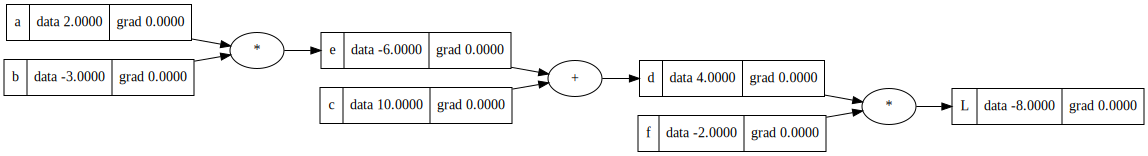

In [4]:
def general_example():

    h = 0.0001

    a = Element(2.0, label='a')
    b = Element(-3.0, label='b')
    c = Element(10.0, label='c')
    e = a * b; e.label = 'e'
    d = e + c; d.label = 'd'
    d, d._prev, d._op
    f = Element(-2.0, label='f')
    L = d * f; L.label='L'
    return L

draw_dot(general_example())

In [5]:
def simple_backprop():
    x1 = Element(2.0, label='x1') 
    x2 = Element(0.0, label='x2') 

    w1 = Element(-3.0, label='w1') 
    w2 = Element(1.0, label='w2') 

    b = Element(7.0, label='b')

    x1w1 = x1*w1; x1w1.label = 'x1*w1'
    x2w2 = x2*w2; x2w2.label = 'x2*w2'

    x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
    n = x1w1x2w2 + b; n.label = 'n'
    o = n.relu(); o.label = 'o'
    o.backward()
    return o

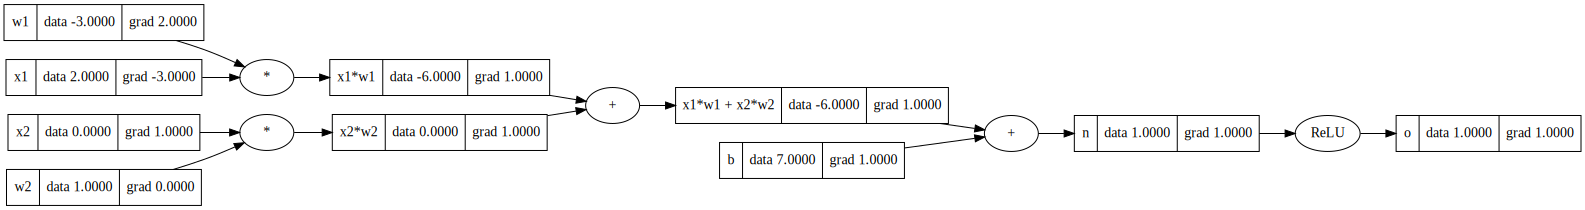

In [6]:
o = simple_backprop()
draw_dot(o)

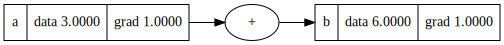

In [7]:
def problem1():
    a = Element(3.0, label='a')
    b = a + a ; b.label = 'b'
    b.backward()
    return b

draw_dot(problem1())

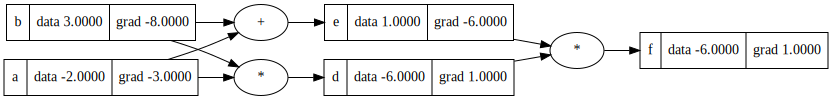

In [8]:
def problem2():
    a = Element(-2.0, label='a')
    b = Element(3.0, label='b')
    d = a * b ;  d.label = 'd'
    e = a + b ;  e.label = 'e'
    f = d * e ;  f.label = 'f'

    f.backward()

    return f

draw_dot(problem2())